# Traing CLIP from scratch for image retrieval (Pytorch)

## Reference :
- ***Blogs***: 
    - [Training CLIP Model from Scratch for an Fashion Image Retrieval App](https://learnopencv.com/clip-model/)
- ***Github***:
    - https://github.com/spmallick/learnopencv/tree/master/Training-CLIP-from-Scratch-for-Image-Retrieval


### conda environment
```
    conda activate cv_playgrounds
```

<img src=https://learnopencv.com/wp-content/uploads/2024/08/CLIP-Product-Search.png>

## Import Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageOps
import pdb
import os
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch

if torch.backends.mps.is_available():
    g_device = "mps"
elif torch.cuda.is_available():
    g_device = "cuda"
    !nvidia-smi
else:
    g_device = "cpu"

print(f"Available device : {g_device}")

Wed Sep 17 12:45:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 25%   45C    P5             39W /  250W |    1460MiB /  11264MiB |     41%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42
 
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
set_seeds()

# Vision Encoder

<img src=https://learnopencv.com/wp-content/uploads/2023/02/image-1024x538.png>

### Transformer Encoder

In [4]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, mlp_ratio =4):
      super().__init__()

      self.d_model = d_model
      self.n_heads = n_heads

      self.ln1 = nn.LayerNorm(d_model)

      self.mha = MultiheadAttention(d_model, n_heads)

      self.ln2 = nn.LayerNorm(d_model)

      self.mlp = nn.Sequential(
          nn.Linear(d_model, d_model*mlp_ratio),
          nn.GELU(),
          nn.Linear(d_model * mlp_ratio, d_model)
      )

#For clip even though its a encoder model it requires mask ->to account for padded for max seq_length
  def forward(self, x, mask = None):

      x_n = self.mha(self.ln1(x), mask = mask)
      x = x + self.mlp(self.ln2(x_n))

      return x  # x.shape -->  [B,max_seq_len,d_model]

<img src=https://miro.medium.com/v2/resize:fit:720/format:webp/0*N99XOqa8iH4WK_u9>

### Multi Head Attention

In [5]:
class MultiheadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
      super().__init__()

      # d_model --> embed dimension 
      # n_heads --> number of heads 
      self.qkv_dim = d_model //  n_heads #or self.head_size

      self.W_o = nn.Linear(d_model,d_model) #Dense layer

      self.multi_head = nn.ModuleList([AttentionHead(d_model, self.qkv_dim) for _ in range(n_heads)])

  def forward(self,x,mask = None):

       #x.shape --> [B,max_seq_len,d_model]

      #Concatenates the outputs from all attention heads along the last dimension (dim=-1)

      out = torch.cat([head(x, mask=mask) for head in self.multi_head], dim = -1) #  [B,max_seq_len,d_model]

      # Apply the linear transformation
      out = self.W_o(out)   #---> (Concat --> Dense)  -- [B,max_seq_len,d_model]

      return out

### AttentionHead

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*nc_6eJDIlzGTqJAAihLPGA.png">

In [6]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, qkv_dim):
      super().__init__()

      self.qkv_dim = qkv_dim

      self.query = nn.Linear(d_model, qkv_dim)
      self.key = nn.Linear(d_model, qkv_dim)
      self.value = nn.Linear(d_model, qkv_dim)

  def forward(self, x, mask = None):
      # x.shape -->  [B,max_seq_len,d_model]
      Q = self.query(x) #[B,max_seq_len,vit_heads]
      K = self.key(x)
      V = self.value(x)

      attention = Q @ K.transpose(-2,-1) #eg: -2 -second last dim and -1 last dim -->  [B,max_seq_len,max_seq_len]
      #Scaling
      attention = attention / self.qkv_dim ** 0.5  #  [B,max_seq_len,max_seq_len]

      #Apply attention mask for padded sequence
      if mask is not None:
         mask = attention.masked_fill(mask == 0, float("-inf")) # torch.tensor.masked_fill

      # Apply softmax to obtain attention weights [Wij]
      attention  = torch.softmax(attention, dim = -1) #along last dim  # (softmax(Q_K^T)/sqrt(d_k)).V -->  [B,max_seq_len,max_seq_len]

      attention = attention @ V #  [B,max_seq_len,max_seq_len]

      return attention  #Y_i

### Positional Embedding

<img src=https://learnopencv.com/wp-content/uploads/2024/08/Positional-Encoding-ViT-CLIP.png>

In [7]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

### ViT Encoder - Vision Encoder

In [8]:
class VisionEncoder(nn.Module):

    def __init__(self, d_model,img_size,patch_size, n_channels, n_heads,n_layers, emb_dim):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] ==0, "image dimensions should be divisible by patch dim"
        assert d_model % n_heads == 0, "d_model should be divisible by n_heads"

        self.num_patches = (img_size[0] * img_size[1] ) // (patch_size[0] * patch_size[1]) # max_seq_length

        self.max_seq_length = self.num_patches +1

        self.linear_proj = nn.Conv2d(in_channels = n_channels,out_channels = d_model, kernel_size = patch_size[0], stride = patch_size[0])

        self.cls_token = nn.Parameter(torch.randn(1,1,d_model), requires_grad = True)

        self.positional_embedding =  PositionalEmbedding(d_model, self.max_seq_length)

        self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

        self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

    def forward(self,x, mask = None):
       
        x  = self.linear_proj(x)  # (B, C, H, W) -> (B, d_model, Patch_col_d_model, Patch_row_height)  

        x = x.flatten(2).transpose(-2, -1)   # (B, d_model, Patch_col_d_model, Patch_row_height) --> Flatten (B, d_model, Patch) --> .transpose(-2,-1) (B, Patch, d_model)
        
        # The input to the transformer we need to pass a sequence of patches or tokens so we need num_patches to be before hidden dim

        x = torch.cat((self.cls_token.expand(x.shape[0], -1,-1), x), dim = 1) #add cls token at the beginning of patch_sequence   -->  [B,max_seq_len,d_model]

        x =  self.positional_embedding(x)  #  [B,max_seq_len,d_model]

        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x, mask)  #  [B, d_model]

        # Get learned class tokens
        x = x[:, 0, :] 

        # Project to shared embedding space
        if self.projection is not None:
           x  = x  @ self.projection  #[B, emb_dim]

        x  = x  / torch.norm(x , dim = -1 , keepdim = True) 


        return x

# Text Encoder

<img src =https://learnopencv.com/wp-content/uploads/2024/08/CLIP-Tokenization.png>

### Tokenization

In [9]:
def tokenizer(text, encode=True, mask=None, max_seq_length=32):
    if encode:
        # Adding SOT and EOT tokens
        out = chr(2) + text + chr(3)
        
        # Truncate if length exceeds max_seq_length
        if len(out) > max_seq_length:
            out = out[:max_seq_length]
        
        # Add padding if needed
        out = out + "".join([chr(0) for _ in range(max_seq_length - len(out))])
        
        # Encode the text
        out = torch.IntTensor(list(out.encode("utf-8")))
        
        # Create the mask
        mask = torch.ones(len(out.nonzero()))
        
        # Pad the mask to max_seq_length
        if len(mask) < max_seq_length:
            mask = torch.cat((mask, torch.zeros(max_seq_length - len(mask)))).type(torch.IntTensor)
        else:
            mask = mask.type(torch.IntTensor)
    else:
        # Decode the text
        out = [chr(x) for x in text[1:len(mask.nonzero()) - 1]]
        out = "".join(out)
        mask = None

    return out, mask


### Text Encoder

<img src=https://learnopencv.com/wp-content/uploads/2024/08/text-encoding-utf-8-clip-text-encoder-embedding-1.gif>

In [10]:
class TextEncoder(nn.Module):
  def __init__(self, vocab_size, d_model, max_seq_length, n_layers,n_heads, emb_dim):
      super().__init__()

      self.max_seq_length = max_seq_length

      self.embed = nn.Embedding(vocab_size, d_model)

      self.positional_embedding = PositionalEmbedding(d_model, max_seq_length)

      self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

      self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

   # For training
  def forward(self, text, mask = None):

      x = self.embed(text)

      x = self.positional_embedding(x)

      for encoder_layer in self.transformer_encoder:
          x = encoder_layer(x, mask=mask)

      #The output of the encoder layers is the text features. We are going to be using the features from the EOT embedding.

      x = x[torch.arange(text.shape[0]), torch.sub(torch.sum(mask[:,0],dim=1),1)]

      if self.projection is not None:
         x = x @ self.projection

      x = x / torch.norm(x, dim=-1, keepdim = True)

      return x


In [11]:
class TextEncoder_Retrieval(nn.Module):
  def __init__(self, vocab_size, d_model, max_seq_length, n_layers,n_heads, emb_dim):
      super().__init__()

      self.max_seq_length = max_seq_length

      self.embed = nn.Embedding(vocab_size, d_model)

      self.positional_embedding = PositionalEmbedding(d_model, max_seq_length)

      self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

      self.projection = nn.Parameter(torch.randn(d_model, emb_dim))


 # # For image retrieval
  def forward(self, text, mask=None):
        x = self.embed(text)
        x = self.positional_embedding(x)
    
        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x, mask=mask)
    
        if mask is not None:
            # Get the lengths of each sequence (i.e., find the last non-padded token)
            seq_lengths = mask.sum(dim=1) - 1  # Subtract 1 to get the index
            x = x[torch.arange(text.shape[0]), seq_lengths]
        else:
            x = x[:, -1]  # If no mask is provided, take the last token in the sequence.
    
        if self.projection is not None:
            x = x @ self.projection
    
        x = x / torch.norm(x, dim=-1, keepdim=True)
    
        return x

# CLIP

<img src=https://learnopencv.com/wp-content/uploads/2024/08/CLIP-Architecture-Explained-OpenAI.png>

In [12]:
class CLIP(nn.Module):

    def __init__(self, emb_dim, vit_layers, vit_d_model, img_size, patch_size, n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers, text_d_model, retrieval = False):
        super().__init__()

        self.vision_encoder = VisionEncoder(vit_d_model, img_size, patch_size, n_channels, vit_heads, vit_layers, emb_dim)
        # print(retrieval)
        if retrieval:
            self.text_encoder = TextEncoder_Retrieval(vocab_size, text_d_model, max_seq_length, text_layers, text_heads, emb_dim)
        else:
            self.text_encoder = TextEncoder(vocab_size, text_d_model, max_seq_length, text_layers, text_heads, emb_dim)
            
        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.device = g_device # rch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def CLIPLoss(self, logits, device = "cuda"):
        #Symmetric or Contrastive loss
    # arange generates a list between 0 and n-1
        labels = torch.arange(logits.shape[0]).to(device)  # For row 1 we want 1,1 to be max, and row n-1 we want (n-1,n-1) text pairs to be max --> time 15.43 umar

        loss_v = nn.functional.cross_entropy(logits.transpose(-2,-1), labels)

        loss_t = nn.functional.cross_entropy(logits, labels)
        loss = (loss_v + loss_t) / 2

        return loss

    def forward(self, image, text, mask=None):
        V_e = self.vision_encoder(image)  # Vision encoder output [B, emb_dim]
        T_e = self.text_encoder(text, mask)  # Text encoder output [B, emb_dim]
        # print(f"V_e shape: {V_e.shape}, T_e shape: {T_e.shape}")

        logits = (V_e @ T_e.transpose(-2, -1)) * torch.exp(self.temperature)
        
        loss = self.CLIPLoss(logits, self.device)
        
        return loss

In [13]:
# Vision
emb_dim = 128 
vit_d_model = 32 # vit_heads * vit_layers = vit_d_model
img_size = (80,80)
patch_size = (5,5) 
n_channels = 3
vit_layers = 8
vit_heads = 4 

# Text
vocab_size = 256
text_d_model = 64 #  -->  text_heads * text_layers = text_d_model
max_seq_length = 128
text_heads = 8
text_layers = 8
lr = 1e-3
epochs = 300
batch_size = 256

# DATASET PREPARATION

<img src=https://learnopencv.com/wp-content/uploads/2024/08/CLIP-Text2Img-Retrieval-Embedding0Product-Search-Fashion.gif>

In [14]:
# !kaggle datasets download -d paramaggarwal/fashion-product-images-small -q
import kagglehub
data_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
print(f"Data path : {data_path}")

Data path : /home/hyunjae/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1


In [15]:
# Load the dataset
csv_path = os.path.join(data_path, "styles.csv")
# df = pd.read_csv('fashion/myntradataset/styles.csv', usecols=['id',  'subCategory'])
df = pd.read_csv(csv_path, usecols=['id',  'subCategory'])

unique, counts = np.unique(df["subCategory"].tolist(), return_counts = True)
print(f"Classes: {unique}: {counts}")

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.10, random_state=42)

# Print the sizes of the datasets
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")
class_names = df['subCategory'].unique()
class_names = [str(name).lower() for name in class_names]

# Replace in-place
for i, name in enumerate(class_names):
    if name == "lips":
        class_names[i] = "lipstick"
    elif name == "eyes":
        class_names[i] = "eyelash"
    elif name == "nails":
        class_names[i] = "nail polish"

captions = {idx: class_name for idx, class_name in enumerate(class_names)}

for idx, caption in captions.items():
    print(f"{idx}: {caption}\n")  

Classes: ['Accessories' 'Apparel Set' 'Bags' 'Bath and Body' 'Beauty Accessories'
 'Belts' 'Bottomwear' 'Cufflinks' 'Dress' 'Eyes' 'Eyewear' 'Flip Flops'
 'Fragrance' 'Free Gifts' 'Gloves' 'Hair' 'Headwear' 'Home Furnishing'
 'Innerwear' 'Jewellery' 'Lips' 'Loungewear and Nightwear' 'Makeup'
 'Mufflers' 'Nails' 'Perfumes' 'Sandal' 'Saree' 'Scarves'
 'Shoe Accessories' 'Shoes' 'Skin' 'Skin Care' 'Socks'
 'Sports Accessories' 'Sports Equipment' 'Stoles' 'Ties' 'Topwear'
 'Umbrellas' 'Vouchers' 'Wallets' 'Watches' 'Water Bottle' 'Wristbands']: [  143   106  3055    12     4   811  2694   108   478    43  1073   915
  1012   104    20    19   293     1  1808  1080   527   470   307    38
   329     6   963   427   118    24  7344    69    77   698     3    21
    90   258 15405     6     1   933  2542     7     4]
Train size: 40001, Validation size: 4445
0: topwear

1: bottomwear

2: watches

3: socks

4: shoes

5: belts

6: flip flops

7: bags

8: innerwear

9: sandal

10: shoe accessorie

In [16]:
class MyntraDataset(Dataset):
    def __init__(self, data_frame, captions, target_size=28):
        
        self.data_frame = data_frame[data_frame['subCategory'].str.lower() != 'innerwear']
        self.target_size = target_size  # Desired size for the square image
        self.transform = T.Compose([
            T.ToTensor()  # Convert image to tensor
        ])

        self.captions = captions

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        while True:
            sample = self.data_frame.iloc[idx]
            # img_path = os.path.join("fashion/myntradataset/images", f"{sample['id']}.jpg")
            # print(f"{sample['id']}.jpg", img_path)
            img_path = os.path.join(data_path, "images", f"{sample['id']}.jpg")
            
            try:
                # Attempt to open the image
                image = Image.open(img_path).convert('RGB')
            except (FileNotFoundError, IOError):
                # If the image is not found, skip this sample by incrementing the index
                idx = (idx + 1) % len(self.data_frame)  # Loop back to the start if we reach the end
                continue  # Retry with the next index
            
            # Resize the image to maintain aspect ratio
            image = self.resize_and_pad(image, self.target_size)
            
            # Apply transformations (convert to tensor)
            image = self.transform(image)

            # Retrieve the subCategory label and its corresponding caption
            label = sample['subCategory'].lower()
            label = {"lips": "lipstick", "eyes": "eyelash", "nails": "nail polish"}.get(label, label)
            
            label_idx = next(idx for idx, class_name in self.captions.items() if class_name == label)

            # # Tokenize the caption using the tokenizer function
            cap, mask = tokenizer(self.captions[label_idx])
            
            # Make sure the mask is a tensor
            mask = torch.tensor(mask)
            
            # If the mask is a single dimension, make sure it is expanded correctly
            if len(mask.size()) == 1:
                mask = mask.unsqueeze(0)

            return {"image": image, "caption": cap, "mask": mask,"id": img_path}

    def resize_and_pad(self, image, target_size):
        original_width, original_height = image.size
        aspect_ratio = original_width / original_height
        
        if aspect_ratio > 1:
            new_width = target_size
            new_height = int(target_size / aspect_ratio)
        else:
            new_height = target_size
            new_width = int(target_size * aspect_ratio)
        
        image = image.resize((new_width, new_height))
        
        pad_width = (target_size - new_width) // 2
        pad_height = (target_size - new_height) // 2
        
        padding = (pad_width, pad_height, target_size - new_width - pad_width, target_size - new_height - pad_height)
        image = ImageOps.expand(image, padding, fill=(0, 0, 0))
        
        return image

#Create datasets
train_dataset = MyntraDataset(data_frame=train_df ,captions = captions, target_size =80)
val_dataset = MyntraDataset(data_frame=val_df ,captions = captions ,target_size =80)
test_dataset = MyntraDataset(data_frame=val_df, captions = captions, target_size = 224)


print("Number of Samples in Train Dataset:", len(train_dataset))
print("Number of Samples in Validation Dataset:", len(val_dataset))


train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size,num_workers = 5)
val_loader  = DataLoader(val_dataset, shuffle = False, batch_size = batch_size,num_workers = 5)
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = batch_size, num_workers = 5)

#Sanity check of dataloader initialization
len(next(iter(train_loader)))  #(img_tensor,label_tensor)

Number of Samples in Train Dataset: 38360
Number of Samples in Validation Dataset: 4278


4

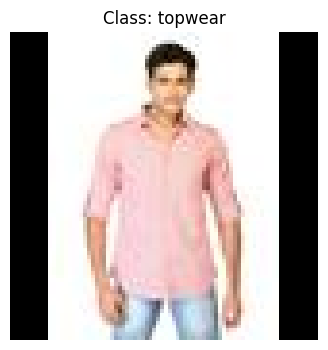

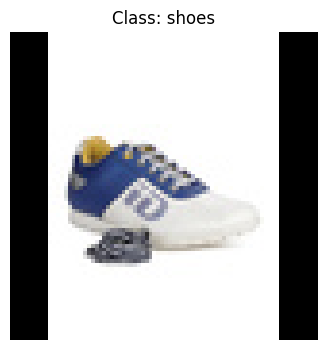

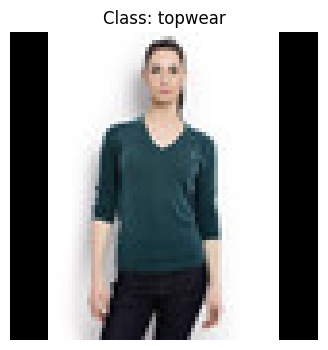

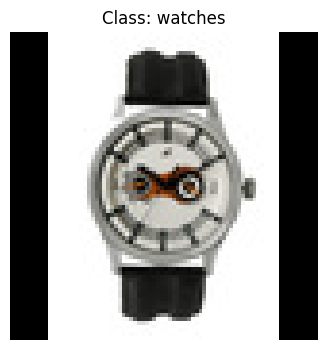

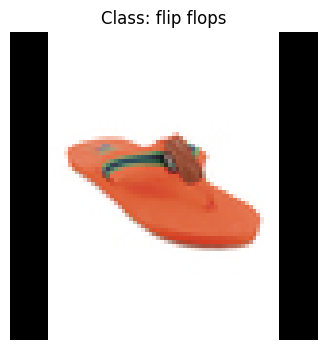

In [17]:
# Function to visualize a batch of images with their class names
def visualize_samples(dataset, tokenizer, num_samples=5):
    # Get a batch of samples
    for i in range(num_samples):
        sample = dataset[i]  # Access the ith sample in the dataset
        image = sample['image']
        tokenized_caption = sample['caption']
        mask = sample['mask'][0]
        
        # Decode the tokenized caption to get the original class name
        original_caption = tokenizer(tokenized_caption, encode=False, mask=mask)[0]
        
        # Convert the tensor image back to a PIL image for visualization
        image = T.ToPILImage()(image)
        
        # Display the image
        plt.figure(figsize=(4, 4))
        plt.imshow(image,cmap="gray")
        plt.title(f"Class: {original_caption}")  # Display the non-tokenized class name as title
        plt.axis('off')
        plt.show()

# Visualize samples from the train dataset
visualize_samples(train_dataset, tokenizer, num_samples=5)

# Training CLIP

In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = g_device
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")


model = CLIP(emb_dim, vit_layers, vit_d_model, img_size,patch_size,n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers,text_d_model, retrieval = False).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)

Using device:  cuda (NVIDIA GeForce RTX 2080 Ti)


In [19]:
from pathlib import Path

model_dir = "./temp/clip_model"
Path(model_dir).mkdir(exist_ok=True, parents=True)
best_model_path = os.path.join(model_dir, "best_clip.pt")

In [20]:
total_params = 0

total_params = sum([ param.numel() for param in model.parameters() if param.requires_grad])

print(f"Total number of trainable parameters: {total_params}; i.e., {total_params/1000000:.2f} M")

Total number of trainable parameters: 532641; i.e., 0.53 M


In [21]:
best_loss = np.inf
for epoch in range(epochs):
    epoch_loss = 0.0  # To accumulate the loss over the epoch
    with tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch [{epoch+1}/{epochs}]") as tepoch:
        for i, data in tepoch:
            img, cap, mask = data["image"].to(device), data["caption"].to(device), data["mask"].to(device)
            optimizer.zero_grad()
            loss = model(img, cap, mask)
            loss.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            tepoch.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.3f}")

    # Save model if it performed better than the previous best
    if avg_loss <= best_loss:
        best_loss = avg_loss
        
        torch.save(model.state_dict(), best_model_path)
        print("Model Saved.")

Epoch [1/300]: 100%|██████████| 150/150 [00:53<00:00,  2.82it/s, loss=4.95]

Epoch [1/300], Average Loss: 5.396
Model Saved.



Epoch [2/300]: 100%|██████████| 150/150 [00:37<00:00,  4.01it/s, loss=3.99]


Epoch [2/300], Average Loss: 4.646
Model Saved.


Epoch [3/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=3.9] 

Epoch [3/300], Average Loss: 4.143
Model Saved.



Epoch [4/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=3.61]


Epoch [4/300], Average Loss: 3.939
Model Saved.


Epoch [5/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.76]


Epoch [5/300], Average Loss: 3.813
Model Saved.


Epoch [6/300]: 100%|██████████| 150/150 [00:33<00:00,  4.41it/s, loss=3.48]

Epoch [6/300], Average Loss: 3.738
Model Saved.



Epoch [7/300]: 100%|██████████| 150/150 [00:38<00:00,  3.94it/s, loss=3.63]


Epoch [7/300], Average Loss: 3.693
Model Saved.


Epoch [8/300]: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s, loss=3.44]


Epoch [8/300], Average Loss: 3.655
Model Saved.


Epoch [9/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.39]


Epoch [9/300], Average Loss: 3.626
Model Saved.


Epoch [10/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.58]


Epoch [10/300], Average Loss: 3.609
Model Saved.


Epoch [11/300]: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s, loss=3.49]


Epoch [11/300], Average Loss: 3.593
Model Saved.


Epoch [12/300]: 100%|██████████| 150/150 [00:35<00:00,  4.21it/s, loss=3.41]


Epoch [12/300], Average Loss: 3.573
Model Saved.


Epoch [13/300]: 100%|██████████| 150/150 [00:36<00:00,  4.13it/s, loss=3.4] 


Epoch [13/300], Average Loss: 3.558
Model Saved.


Epoch [14/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.38]


Epoch [14/300], Average Loss: 3.546
Model Saved.


Epoch [15/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.43]


Epoch [15/300], Average Loss: 3.535
Model Saved.


Epoch [16/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.55]


Epoch [16/300], Average Loss: 3.530
Model Saved.


Epoch [17/300]: 100%|██████████| 150/150 [00:37<00:00,  3.99it/s, loss=3.41]


Epoch [17/300], Average Loss: 3.511
Model Saved.


Epoch [18/300]: 100%|██████████| 150/150 [00:38<00:00,  3.91it/s, loss=3.38]


Epoch [18/300], Average Loss: 3.508
Model Saved.


Epoch [19/300]: 100%|██████████| 150/150 [00:38<00:00,  3.87it/s, loss=3.58]


Epoch [19/300], Average Loss: 3.504
Model Saved.


Epoch [20/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.31]


Epoch [20/300], Average Loss: 3.493
Model Saved.


Epoch [21/300]: 100%|██████████| 150/150 [00:38<00:00,  3.92it/s, loss=3.25]


Epoch [21/300], Average Loss: 3.484
Model Saved.


Epoch [22/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.17]


Epoch [22/300], Average Loss: 3.473
Model Saved.


Epoch [23/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.43]


Epoch [23/300], Average Loss: 3.467
Model Saved.


Epoch [24/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.45]


Epoch [24/300], Average Loss: 3.461
Model Saved.


Epoch [25/300]: 100%|██████████| 150/150 [00:35<00:00,  4.26it/s, loss=3.18]


Epoch [25/300], Average Loss: 3.457
Model Saved.


Epoch [26/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.31]


Epoch [26/300], Average Loss: 3.449
Model Saved.


Epoch [27/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.24]


Epoch [27/300], Average Loss: 3.445
Model Saved.


Epoch [28/300]: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s, loss=3.22]

Epoch [28/300], Average Loss: 3.447



Epoch [29/300]: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s, loss=3.26]


Epoch [29/300], Average Loss: 3.437
Model Saved.


Epoch [30/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.18]


Epoch [30/300], Average Loss: 3.435
Model Saved.


Epoch [31/300]: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s, loss=3.33]


Epoch [31/300], Average Loss: 3.428
Model Saved.


Epoch [32/300]: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s, loss=3.16]


Epoch [32/300], Average Loss: 3.422
Model Saved.


Epoch [33/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.3] 


Epoch [33/300], Average Loss: 3.422
Model Saved.


Epoch [34/300]: 100%|██████████| 150/150 [00:38<00:00,  3.88it/s, loss=3.25]


Epoch [34/300], Average Loss: 3.419
Model Saved.


Epoch [35/300]: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s, loss=3.45]


Epoch [35/300], Average Loss: 3.415
Model Saved.


Epoch [36/300]: 100%|██████████| 150/150 [00:36<00:00,  4.13it/s, loss=3.21]


Epoch [36/300], Average Loss: 3.403
Model Saved.


Epoch [37/300]: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s, loss=3.29]


Epoch [37/300], Average Loss: 3.403
Model Saved.


Epoch [38/300]: 100%|██████████| 150/150 [00:35<00:00,  4.20it/s, loss=3.3] 


Epoch [38/300], Average Loss: 3.402
Model Saved.


Epoch [39/300]: 100%|██████████| 150/150 [00:35<00:00,  4.18it/s, loss=3.29]


Epoch [39/300], Average Loss: 3.395
Model Saved.


Epoch [40/300]: 100%|██████████| 150/150 [00:38<00:00,  3.92it/s, loss=3.17]


Epoch [40/300], Average Loss: 3.392
Model Saved.


Epoch [41/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.18]


Epoch [41/300], Average Loss: 3.388
Model Saved.


Epoch [42/300]: 100%|██████████| 150/150 [00:37<00:00,  3.99it/s, loss=3.24]

Epoch [42/300], Average Loss: 3.389



Epoch [43/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=3.15]

Epoch [43/300], Average Loss: 3.388



Epoch [44/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.2] 


Epoch [44/300], Average Loss: 3.386
Model Saved.


Epoch [45/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.21]


Epoch [45/300], Average Loss: 3.382
Model Saved.


Epoch [46/300]: 100%|██████████| 150/150 [00:38<00:00,  3.92it/s, loss=3.2] 


Epoch [46/300], Average Loss: 3.370
Model Saved.


Epoch [47/300]: 100%|██████████| 150/150 [00:38<00:00,  3.89it/s, loss=3.31]

Epoch [47/300], Average Loss: 3.372



Epoch [48/300]: 100%|██████████| 150/150 [00:37<00:00,  3.97it/s, loss=3.09]

Epoch [48/300], Average Loss: 3.375



Epoch [49/300]: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s, loss=3.14]


Epoch [49/300], Average Loss: 3.367
Model Saved.


Epoch [50/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.25]

Epoch [50/300], Average Loss: 3.368



Epoch [51/300]: 100%|██████████| 150/150 [00:37<00:00,  4.00it/s, loss=3.03]


Epoch [51/300], Average Loss: 3.362
Model Saved.


Epoch [52/300]: 100%|██████████| 150/150 [00:38<00:00,  3.91it/s, loss=3.26]

Epoch [52/300], Average Loss: 3.363



Epoch [53/300]: 100%|██████████| 150/150 [00:38<00:00,  3.90it/s, loss=3.37]


Epoch [53/300], Average Loss: 3.361
Model Saved.


Epoch [54/300]: 100%|██████████| 150/150 [00:35<00:00,  4.19it/s, loss=3.08]


Epoch [54/300], Average Loss: 3.352
Model Saved.


Epoch [55/300]: 100%|██████████| 150/150 [00:35<00:00,  4.19it/s, loss=3.18]


Epoch [55/300], Average Loss: 3.352
Model Saved.


Epoch [56/300]: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s, loss=3.21]

Epoch [56/300], Average Loss: 3.370



Epoch [57/300]: 100%|██████████| 150/150 [00:37<00:00,  4.00it/s, loss=3.14]

Epoch [57/300], Average Loss: 3.359



Epoch [58/300]: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s, loss=3.35]


Epoch [58/300], Average Loss: 3.349
Model Saved.


Epoch [59/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.41]

Epoch [59/300], Average Loss: 3.349



Epoch [60/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=3.16]


Epoch [60/300], Average Loss: 3.345
Model Saved.


Epoch [61/300]: 100%|██████████| 150/150 [00:35<00:00,  4.27it/s, loss=3.15]


Epoch [61/300], Average Loss: 3.342
Model Saved.


Epoch [62/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.24]

Epoch [62/300], Average Loss: 3.353



Epoch [63/300]: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s, loss=3.29]

Epoch [63/300], Average Loss: 3.342



Epoch [64/300]: 100%|██████████| 150/150 [00:35<00:00,  4.22it/s, loss=3.16]


Epoch [64/300], Average Loss: 3.341
Model Saved.


Epoch [65/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.22]


Epoch [65/300], Average Loss: 3.336
Model Saved.


Epoch [66/300]: 100%|██████████| 150/150 [00:37<00:00,  4.00it/s, loss=3.15]


Epoch [66/300], Average Loss: 3.335
Model Saved.


Epoch [67/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.18]

Epoch [67/300], Average Loss: 3.336



Epoch [68/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.34]

Epoch [68/300], Average Loss: 3.337



Epoch [69/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.01]

Epoch [69/300], Average Loss: 3.336



Epoch [70/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.22]

Epoch [70/300], Average Loss: 3.343



Epoch [71/300]: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s, loss=3.06]


Epoch [71/300], Average Loss: 3.331
Model Saved.


Epoch [72/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.11]


Epoch [72/300], Average Loss: 3.330
Model Saved.


Epoch [73/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.08]

Epoch [73/300], Average Loss: 3.337



Epoch [74/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.16]

Epoch [74/300], Average Loss: 3.333



Epoch [75/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=3.21]


Epoch [75/300], Average Loss: 3.328
Model Saved.


Epoch [76/300]: 100%|██████████| 150/150 [00:36<00:00,  4.12it/s, loss=3.03]


Epoch [76/300], Average Loss: 3.323
Model Saved.


Epoch [77/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.28]

Epoch [77/300], Average Loss: 3.347



Epoch [78/300]: 100%|██████████| 150/150 [00:35<00:00,  4.18it/s, loss=3.06]

Epoch [78/300], Average Loss: 3.331



Epoch [79/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.06]


Epoch [79/300], Average Loss: 3.320
Model Saved.


Epoch [80/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.07]

Epoch [80/300], Average Loss: 3.323



Epoch [81/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.07]


Epoch [81/300], Average Loss: 3.317
Model Saved.


Epoch [82/300]: 100%|██████████| 150/150 [00:37<00:00,  3.99it/s, loss=3.21]

Epoch [82/300], Average Loss: 3.326



Epoch [83/300]: 100%|██████████| 150/150 [00:36<00:00,  4.13it/s, loss=3.12]

Epoch [83/300], Average Loss: 3.317



Epoch [84/300]: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s, loss=3.07]

Epoch [84/300], Average Loss: 3.320



Epoch [85/300]: 100%|██████████| 150/150 [00:35<00:00,  4.20it/s, loss=3.32]

Epoch [85/300], Average Loss: 3.321



Epoch [86/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=3.06]

Epoch [86/300], Average Loss: 3.318



Epoch [87/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.26]

Epoch [87/300], Average Loss: 3.323



Epoch [88/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.2] 


Epoch [88/300], Average Loss: 3.313
Model Saved.


Epoch [89/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=3.31]


Epoch [89/300], Average Loss: 3.313
Model Saved.


Epoch [90/300]: 100%|██████████| 150/150 [00:36<00:00,  4.12it/s, loss=3.1] 

Epoch [90/300], Average Loss: 3.318



Epoch [91/300]: 100%|██████████| 150/150 [00:35<00:00,  4.22it/s, loss=3.31]

Epoch [91/300], Average Loss: 3.318



Epoch [92/300]: 100%|██████████| 150/150 [00:34<00:00,  4.31it/s, loss=3.06]

Epoch [92/300], Average Loss: 3.312
Model Saved.



Epoch [93/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.21]


Epoch [93/300], Average Loss: 3.311
Model Saved.


Epoch [94/300]: 100%|██████████| 150/150 [00:34<00:00,  4.36it/s, loss=3.24]

Epoch [94/300], Average Loss: 3.314



Epoch [95/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.24]

Epoch [95/300], Average Loss: 3.312



Epoch [96/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.17]

Epoch [96/300], Average Loss: 3.311



Epoch [97/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.23]


Epoch [97/300], Average Loss: 3.305
Model Saved.


Epoch [98/300]: 100%|██████████| 150/150 [00:35<00:00,  4.17it/s, loss=3.23]

Epoch [98/300], Average Loss: 3.309



Epoch [99/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.02]

Epoch [99/300], Average Loss: 3.311



Epoch [100/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.21]

Epoch [100/300], Average Loss: 3.307



Epoch [101/300]: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s, loss=3.2] 

Epoch [101/300], Average Loss: 3.307



Epoch [102/300]: 100%|██████████| 150/150 [00:39<00:00,  3.83it/s, loss=3.26]


Epoch [102/300], Average Loss: 3.301
Model Saved.


Epoch [103/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.27]

Epoch [103/300], Average Loss: 3.305



Epoch [104/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.11]

Epoch [104/300], Average Loss: 3.305



Epoch [105/300]: 100%|██████████| 150/150 [00:35<00:00,  4.26it/s, loss=3.3] 

Epoch [105/300], Average Loss: 3.305



Epoch [106/300]: 100%|██████████| 150/150 [00:34<00:00,  4.37it/s, loss=3.08]

Epoch [106/300], Average Loss: 3.306



Epoch [107/300]: 100%|██████████| 150/150 [00:38<00:00,  3.91it/s, loss=3.14]

Epoch [107/300], Average Loss: 3.306



Epoch [108/300]: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s, loss=3.18]


Epoch [108/300], Average Loss: 3.295
Model Saved.


Epoch [109/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.05]

Epoch [109/300], Average Loss: 3.309



Epoch [110/300]: 100%|██████████| 150/150 [00:36<00:00,  4.13it/s, loss=3.13]

Epoch [110/300], Average Loss: 3.311



Epoch [111/300]: 100%|██████████| 150/150 [00:35<00:00,  4.23it/s, loss=3.11]

Epoch [111/300], Average Loss: 3.308



Epoch [112/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=2.97]

Epoch [112/300], Average Loss: 3.310



Epoch [113/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.27]

Epoch [113/300], Average Loss: 3.308



Epoch [114/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.18]

Epoch [114/300], Average Loss: 3.298



Epoch [115/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.15]

Epoch [115/300], Average Loss: 3.300



Epoch [116/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.12]

Epoch [116/300], Average Loss: 3.319



Epoch [117/300]: 100%|██████████| 150/150 [00:36<00:00,  4.13it/s, loss=3.1] 

Epoch [117/300], Average Loss: 3.296



Epoch [118/300]: 100%|██████████| 150/150 [00:35<00:00,  4.28it/s, loss=3.24]

Epoch [118/300], Average Loss: 3.288
Model Saved.



Epoch [119/300]: 100%|██████████| 150/150 [00:36<00:00,  4.13it/s, loss=3.26]

Epoch [119/300], Average Loss: 3.297



Epoch [120/300]: 100%|██████████| 150/150 [00:38<00:00,  3.91it/s, loss=3.32]

Epoch [120/300], Average Loss: 3.299



Epoch [121/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=3.36]

Epoch [121/300], Average Loss: 3.308



Epoch [122/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.08]

Epoch [122/300], Average Loss: 3.299



Epoch [123/300]: 100%|██████████| 150/150 [00:34<00:00,  4.40it/s, loss=3.18]

Epoch [123/300], Average Loss: 3.299



Epoch [124/300]: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s, loss=3.06]

Epoch [124/300], Average Loss: 3.300



Epoch [125/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=2.96]

Epoch [125/300], Average Loss: 3.294



Epoch [126/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.19]

Epoch [126/300], Average Loss: 3.293



Epoch [127/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.14]

Epoch [127/300], Average Loss: 3.295



Epoch [128/300]: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s, loss=3.15]

Epoch [128/300], Average Loss: 3.301



Epoch [129/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=2.99]

Epoch [129/300], Average Loss: 3.302



Epoch [130/300]: 100%|██████████| 150/150 [00:35<00:00,  4.26it/s, loss=3.18]

Epoch [130/300], Average Loss: 3.294



Epoch [131/300]: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s, loss=3.15]


Epoch [131/300], Average Loss: 3.282
Model Saved.


Epoch [132/300]: 100%|██████████| 150/150 [00:35<00:00,  4.17it/s, loss=3.12]

Epoch [132/300], Average Loss: 3.292



Epoch [133/300]: 100%|██████████| 150/150 [00:34<00:00,  4.31it/s, loss=2.99]

Epoch [133/300], Average Loss: 3.300



Epoch [134/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.28]

Epoch [134/300], Average Loss: 3.300



Epoch [135/300]: 100%|██████████| 150/150 [00:35<00:00,  4.21it/s, loss=3.24]

Epoch [135/300], Average Loss: 3.295



Epoch [136/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.23]

Epoch [136/300], Average Loss: 3.284



Epoch [137/300]: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s, loss=2.96]

Epoch [137/300], Average Loss: 3.292



Epoch [138/300]: 100%|██████████| 150/150 [00:35<00:00,  4.21it/s, loss=3.06]

Epoch [138/300], Average Loss: 3.287



Epoch [139/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=3.09]

Epoch [139/300], Average Loss: 3.291



Epoch [140/300]: 100%|██████████| 150/150 [00:37<00:00,  4.00it/s, loss=2.97]

Epoch [140/300], Average Loss: 3.296



Epoch [141/300]: 100%|██████████| 150/150 [00:35<00:00,  4.18it/s, loss=3.02]

Epoch [141/300], Average Loss: 3.301



Epoch [142/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.22]

Epoch [142/300], Average Loss: 3.296



Epoch [143/300]: 100%|██████████| 150/150 [00:36<00:00,  4.12it/s, loss=3.15]

Epoch [143/300], Average Loss: 3.294



Epoch [144/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.07]

Epoch [144/300], Average Loss: 3.285



Epoch [145/300]: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s, loss=3.11]

Epoch [145/300], Average Loss: 3.287



Epoch [146/300]: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s, loss=3.27]

Epoch [146/300], Average Loss: 3.286



Epoch [147/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.2] 

Epoch [147/300], Average Loss: 3.297



Epoch [148/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=3.01]

Epoch [148/300], Average Loss: 3.290



Epoch [149/300]: 100%|██████████| 150/150 [00:35<00:00,  4.26it/s, loss=3.2] 

Epoch [149/300], Average Loss: 3.286



Epoch [150/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=3.11]

Epoch [150/300], Average Loss: 3.287



Epoch [151/300]: 100%|██████████| 150/150 [00:35<00:00,  4.23it/s, loss=3.29]

Epoch [151/300], Average Loss: 3.291



Epoch [152/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=3.19]

Epoch [152/300], Average Loss: 3.287



Epoch [153/300]: 100%|██████████| 150/150 [00:37<00:00,  4.01it/s, loss=3.05]

Epoch [153/300], Average Loss: 3.290



Epoch [154/300]: 100%|██████████| 150/150 [00:35<00:00,  4.26it/s, loss=3.07]

Epoch [154/300], Average Loss: 3.290



Epoch [155/300]: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s, loss=3.08]

Epoch [155/300], Average Loss: 3.286



Epoch [156/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.22]


Epoch [156/300], Average Loss: 3.281
Model Saved.


Epoch [157/300]: 100%|██████████| 150/150 [00:34<00:00,  4.32it/s, loss=3.17]

Epoch [157/300], Average Loss: 3.292



Epoch [158/300]: 100%|██████████| 150/150 [00:33<00:00,  4.51it/s, loss=3.01]

Epoch [158/300], Average Loss: 3.298



Epoch [159/300]: 100%|██████████| 150/150 [00:36<00:00,  4.13it/s, loss=3.18]

Epoch [159/300], Average Loss: 3.290



Epoch [160/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.23]

Epoch [160/300], Average Loss: 3.287



Epoch [161/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.14]

Epoch [161/300], Average Loss: 3.291



Epoch [162/300]: 100%|██████████| 150/150 [00:34<00:00,  4.40it/s, loss=3.15]

Epoch [162/300], Average Loss: 3.283



Epoch [163/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.06]

Epoch [163/300], Average Loss: 3.284



Epoch [164/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.18]

Epoch [164/300], Average Loss: 3.295



Epoch [165/300]: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s, loss=3.1] 

Epoch [165/300], Average Loss: 3.284



Epoch [166/300]: 100%|██████████| 150/150 [00:35<00:00,  4.17it/s, loss=3.17]

Epoch [166/300], Average Loss: 3.287



Epoch [167/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.07]

Epoch [167/300], Average Loss: 3.288



Epoch [168/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.12]

Epoch [168/300], Average Loss: 3.285



Epoch [169/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=3.18]

Epoch [169/300], Average Loss: 3.292



Epoch [170/300]: 100%|██████████| 150/150 [00:38<00:00,  3.92it/s, loss=3.37]

Epoch [170/300], Average Loss: 3.286



Epoch [171/300]: 100%|██████████| 150/150 [00:37<00:00,  3.97it/s, loss=3.17]

Epoch [171/300], Average Loss: 3.283



Epoch [172/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.24]

Epoch [172/300], Average Loss: 3.286



Epoch [173/300]: 100%|██████████| 150/150 [00:36<00:00,  4.05it/s, loss=3.08]

Epoch [173/300], Average Loss: 3.285



Epoch [174/300]: 100%|██████████| 150/150 [00:33<00:00,  4.54it/s, loss=3.2] 

Epoch [174/300], Average Loss: 3.289



Epoch [175/300]: 100%|██████████| 150/150 [00:35<00:00,  4.21it/s, loss=3.1] 

Epoch [175/300], Average Loss: 3.287



Epoch [176/300]: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s, loss=2.99]

Epoch [176/300], Average Loss: 3.307



Epoch [177/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=3.15]

Epoch [177/300], Average Loss: 3.293



Epoch [178/300]: 100%|██████████| 150/150 [00:35<00:00,  4.22it/s, loss=3.25]


Epoch [178/300], Average Loss: 3.276
Model Saved.


Epoch [179/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.1] 

Epoch [179/300], Average Loss: 3.287



Epoch [180/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.05]

Epoch [180/300], Average Loss: 3.277



Epoch [181/300]: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s, loss=3.12]


Epoch [181/300], Average Loss: 3.272
Model Saved.


Epoch [182/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.25]

Epoch [182/300], Average Loss: 3.289



Epoch [183/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=3.15]

Epoch [183/300], Average Loss: 3.301



Epoch [184/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.05]

Epoch [184/300], Average Loss: 3.280



Epoch [185/300]: 100%|██████████| 150/150 [00:37<00:00,  4.00it/s, loss=3.08]

Epoch [185/300], Average Loss: 3.284



Epoch [186/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.18]

Epoch [186/300], Average Loss: 3.276



Epoch [187/300]: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s, loss=3.17]

Epoch [187/300], Average Loss: 3.286



Epoch [188/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.12]

Epoch [188/300], Average Loss: 3.282



Epoch [189/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=3.12]

Epoch [189/300], Average Loss: 3.291



Epoch [190/300]: 100%|██████████| 150/150 [00:34<00:00,  4.37it/s, loss=3.19]

Epoch [190/300], Average Loss: 3.283



Epoch [191/300]: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s, loss=3.14]

Epoch [191/300], Average Loss: 3.277



Epoch [192/300]: 100%|██████████| 150/150 [00:35<00:00,  4.25it/s, loss=3.1] 

Epoch [192/300], Average Loss: 3.284



Epoch [193/300]: 100%|██████████| 150/150 [00:35<00:00,  4.28it/s, loss=3.18]

Epoch [193/300], Average Loss: 3.278



Epoch [194/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.2] 

Epoch [194/300], Average Loss: 3.290



Epoch [195/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.1] 

Epoch [195/300], Average Loss: 3.275



Epoch [196/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.23]

Epoch [196/300], Average Loss: 3.279



Epoch [197/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.15]

Epoch [197/300], Average Loss: 3.285



Epoch [198/300]: 100%|██████████| 150/150 [00:35<00:00,  4.17it/s, loss=3.17]

Epoch [198/300], Average Loss: 3.288



Epoch [199/300]: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s, loss=3.1] 

Epoch [199/300], Average Loss: 3.282



Epoch [200/300]: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s, loss=3]   

Epoch [200/300], Average Loss: 3.270
Model Saved.



Epoch [201/300]: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s, loss=3.13]

Epoch [201/300], Average Loss: 3.285



Epoch [202/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.01]

Epoch [202/300], Average Loss: 3.281



Epoch [203/300]: 100%|██████████| 150/150 [00:35<00:00,  4.19it/s, loss=3.12]

Epoch [203/300], Average Loss: 3.281



Epoch [204/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=3.04]

Epoch [204/300], Average Loss: 3.273



Epoch [205/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.14]

Epoch [205/300], Average Loss: 3.284



Epoch [206/300]: 100%|██████████| 150/150 [00:35<00:00,  4.18it/s, loss=3.21]

Epoch [206/300], Average Loss: 3.286



Epoch [207/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.39]

Epoch [207/300], Average Loss: 3.279



Epoch [208/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.11]

Epoch [208/300], Average Loss: 3.283



Epoch [209/300]: 100%|██████████| 150/150 [00:37<00:00,  4.00it/s, loss=3.12]

Epoch [209/300], Average Loss: 3.286



Epoch [210/300]: 100%|██████████| 150/150 [00:35<00:00,  4.22it/s, loss=3.14]

Epoch [210/300], Average Loss: 3.282



Epoch [211/300]: 100%|██████████| 150/150 [00:37<00:00,  4.01it/s, loss=3.06]

Epoch [211/300], Average Loss: 3.278



Epoch [212/300]: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s, loss=3.12]

Epoch [212/300], Average Loss: 3.291



Epoch [213/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.11]

Epoch [213/300], Average Loss: 3.278



Epoch [214/300]: 100%|██████████| 150/150 [00:36<00:00,  4.12it/s, loss=2.98]

Epoch [214/300], Average Loss: 3.275



Epoch [215/300]: 100%|██████████| 150/150 [00:35<00:00,  4.18it/s, loss=3.24]

Epoch [215/300], Average Loss: 3.280



Epoch [216/300]: 100%|██████████| 150/150 [00:37<00:00,  3.99it/s, loss=3.24]

Epoch [216/300], Average Loss: 3.277



Epoch [217/300]: 100%|██████████| 150/150 [00:36<00:00,  4.13it/s, loss=3.4] 

Epoch [217/300], Average Loss: 3.277



Epoch [218/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.11]

Epoch [218/300], Average Loss: 3.282



Epoch [219/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.1] 

Epoch [219/300], Average Loss: 3.284



Epoch [220/300]: 100%|██████████| 150/150 [00:35<00:00,  4.23it/s, loss=3.06]

Epoch [220/300], Average Loss: 3.276



Epoch [221/300]: 100%|██████████| 150/150 [00:32<00:00,  4.58it/s, loss=3.23]

Epoch [221/300], Average Loss: 3.284



Epoch [222/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.23]

Epoch [222/300], Average Loss: 3.279



Epoch [223/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.05]

Epoch [223/300], Average Loss: 3.275



Epoch [224/300]: 100%|██████████| 150/150 [00:38<00:00,  3.91it/s, loss=3.31]

Epoch [224/300], Average Loss: 3.281



Epoch [225/300]: 100%|██████████| 150/150 [00:35<00:00,  4.17it/s, loss=3.01]

Epoch [225/300], Average Loss: 3.281



Epoch [226/300]: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s, loss=3.17]

Epoch [226/300], Average Loss: 3.276



Epoch [227/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=3.07]

Epoch [227/300], Average Loss: 3.289



Epoch [228/300]: 100%|██████████| 150/150 [00:37<00:00,  4.01it/s, loss=3.07]

Epoch [228/300], Average Loss: 3.280



Epoch [229/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=2.93]

Epoch [229/300], Average Loss: 3.279



Epoch [230/300]: 100%|██████████| 150/150 [00:36<00:00,  4.12it/s, loss=3.11]


Epoch [230/300], Average Loss: 3.267
Model Saved.


Epoch [231/300]: 100%|██████████| 150/150 [00:35<00:00,  4.21it/s, loss=3.07]

Epoch [231/300], Average Loss: 3.271



Epoch [232/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.08]

Epoch [232/300], Average Loss: 3.285



Epoch [233/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.11]

Epoch [233/300], Average Loss: 3.278



Epoch [234/300]: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s, loss=3.3] 

Epoch [234/300], Average Loss: 3.268



Epoch [235/300]: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s, loss=3.08]

Epoch [235/300], Average Loss: 3.285



Epoch [236/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=2.96]

Epoch [236/300], Average Loss: 3.280



Epoch [237/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.08]

Epoch [237/300], Average Loss: 3.270



Epoch [238/300]: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s, loss=3.04]

Epoch [238/300], Average Loss: 3.275



Epoch [239/300]: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s, loss=3.08]

Epoch [239/300], Average Loss: 3.280



Epoch [240/300]: 100%|██████████| 150/150 [00:35<00:00,  4.19it/s, loss=3.07]

Epoch [240/300], Average Loss: 3.276



Epoch [241/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=2.86]

Epoch [241/300], Average Loss: 3.286



Epoch [242/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.17]

Epoch [242/300], Average Loss: 3.277



Epoch [243/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=3.21]

Epoch [243/300], Average Loss: 3.277



Epoch [244/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=2.97]

Epoch [244/300], Average Loss: 3.280



Epoch [245/300]: 100%|██████████| 150/150 [00:35<00:00,  4.28it/s, loss=3.26]

Epoch [245/300], Average Loss: 3.280



Epoch [246/300]: 100%|██████████| 150/150 [00:37<00:00,  4.01it/s, loss=3.16]

Epoch [246/300], Average Loss: 3.273



Epoch [247/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.06]

Epoch [247/300], Average Loss: 3.285



Epoch [248/300]: 100%|██████████| 150/150 [00:37<00:00,  4.04it/s, loss=3.13]

Epoch [248/300], Average Loss: 3.282



Epoch [249/300]: 100%|██████████| 150/150 [00:36<00:00,  4.13it/s, loss=3.04]

Epoch [249/300], Average Loss: 3.277



Epoch [250/300]: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s, loss=3.1] 

Epoch [250/300], Average Loss: 3.278



Epoch [251/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3]   

Epoch [251/300], Average Loss: 3.270



Epoch [252/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.13]

Epoch [252/300], Average Loss: 3.280



Epoch [253/300]: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s, loss=3.06]

Epoch [253/300], Average Loss: 3.268



Epoch [254/300]: 100%|██████████| 150/150 [00:35<00:00,  4.23it/s, loss=3.13]

Epoch [254/300], Average Loss: 3.282



Epoch [255/300]: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s, loss=3.04]

Epoch [255/300], Average Loss: 3.279



Epoch [256/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=3.04]

Epoch [256/300], Average Loss: 3.278



Epoch [257/300]: 100%|██████████| 150/150 [00:36<00:00,  4.15it/s, loss=3.06]

Epoch [257/300], Average Loss: 3.273



Epoch [258/300]: 100%|██████████| 150/150 [00:37<00:00,  4.01it/s, loss=3.16]

Epoch [258/300], Average Loss: 3.278



Epoch [259/300]: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s, loss=3.11]

Epoch [259/300], Average Loss: 3.276



Epoch [260/300]: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s, loss=3.15]

Epoch [260/300], Average Loss: 3.275



Epoch [261/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=2.91]

Epoch [261/300], Average Loss: 3.276



Epoch [262/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=3.12]

Epoch [262/300], Average Loss: 3.283



Epoch [263/300]: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, loss=3.14]

Epoch [263/300], Average Loss: 3.273



Epoch [264/300]: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s, loss=3.14]

Epoch [264/300], Average Loss: 3.277



Epoch [265/300]: 100%|██████████| 150/150 [00:36<00:00,  4.12it/s, loss=3.1] 

Epoch [265/300], Average Loss: 3.274



Epoch [266/300]: 100%|██████████| 150/150 [00:33<00:00,  4.49it/s, loss=3.18]

Epoch [266/300], Average Loss: 3.270



Epoch [267/300]: 100%|██████████| 150/150 [00:34<00:00,  4.29it/s, loss=3.23]

Epoch [267/300], Average Loss: 3.276



Epoch [268/300]: 100%|██████████| 150/150 [00:36<00:00,  4.12it/s, loss=3.09]


Epoch [268/300], Average Loss: 3.262
Model Saved.


Epoch [269/300]: 100%|██████████| 150/150 [00:35<00:00,  4.25it/s, loss=3.03]

Epoch [269/300], Average Loss: 3.267



Epoch [270/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=3.19]

Epoch [270/300], Average Loss: 3.272



Epoch [271/300]: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, loss=3.14]

Epoch [271/300], Average Loss: 3.285



Epoch [272/300]: 100%|██████████| 150/150 [00:37<00:00,  3.97it/s, loss=3.11]

Epoch [272/300], Average Loss: 3.286



Epoch [273/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.13]

Epoch [273/300], Average Loss: 3.276



Epoch [274/300]: 100%|██████████| 150/150 [00:35<00:00,  4.24it/s, loss=3.15]

Epoch [274/300], Average Loss: 3.276



Epoch [275/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=3.12]

Epoch [275/300], Average Loss: 3.263



Epoch [276/300]: 100%|██████████| 150/150 [00:35<00:00,  4.24it/s, loss=3.02]

Epoch [276/300], Average Loss: 3.277



Epoch [277/300]: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s, loss=3.11]

Epoch [277/300], Average Loss: 3.290



Epoch [278/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.16]

Epoch [278/300], Average Loss: 3.271



Epoch [279/300]: 100%|██████████| 150/150 [00:37<00:00,  4.01it/s, loss=3.15]

Epoch [279/300], Average Loss: 3.268



Epoch [280/300]: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s, loss=3.24]

Epoch [280/300], Average Loss: 3.281



Epoch [281/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.02]

Epoch [281/300], Average Loss: 3.272



Epoch [282/300]: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s, loss=3.12]

Epoch [282/300], Average Loss: 3.268



Epoch [283/300]: 100%|██████████| 150/150 [00:38<00:00,  3.91it/s, loss=3.03]

Epoch [283/300], Average Loss: 3.278



Epoch [284/300]: 100%|██████████| 150/150 [00:35<00:00,  4.23it/s, loss=3.18]

Epoch [284/300], Average Loss: 3.277



Epoch [285/300]: 100%|██████████| 150/150 [00:36<00:00,  4.14it/s, loss=3.02]

Epoch [285/300], Average Loss: 3.271



Epoch [286/300]: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s, loss=3.15]

Epoch [286/300], Average Loss: 3.277



Epoch [287/300]: 100%|██████████| 150/150 [00:35<00:00,  4.19it/s, loss=3.01]

Epoch [287/300], Average Loss: 3.277



Epoch [288/300]: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s, loss=3.12]

Epoch [288/300], Average Loss: 3.279



Epoch [289/300]: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, loss=3.18]

Epoch [289/300], Average Loss: 3.272



Epoch [290/300]: 100%|██████████| 150/150 [00:37<00:00,  3.99it/s, loss=3.21]

Epoch [290/300], Average Loss: 3.270



Epoch [291/300]: 100%|██████████| 150/150 [00:35<00:00,  4.27it/s, loss=3.08]

Epoch [291/300], Average Loss: 3.275



Epoch [292/300]: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s, loss=3.14]

Epoch [292/300], Average Loss: 3.271



Epoch [293/300]: 100%|██████████| 150/150 [00:33<00:00,  4.54it/s, loss=3.09]

Epoch [293/300], Average Loss: 3.267



Epoch [294/300]: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s, loss=3.07]

Epoch [294/300], Average Loss: 3.279



Epoch [295/300]: 100%|██████████| 150/150 [00:37<00:00,  4.00it/s, loss=3.12]

Epoch [295/300], Average Loss: 3.279



Epoch [296/300]: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s, loss=3.18]

Epoch [296/300], Average Loss: 3.270



Epoch [297/300]: 100%|██████████| 150/150 [00:37<00:00,  4.00it/s, loss=3.11]

Epoch [297/300], Average Loss: 3.264



Epoch [298/300]: 100%|██████████| 150/150 [00:34<00:00,  4.32it/s, loss=2.97]

Epoch [298/300], Average Loss: 3.269



Epoch [299/300]: 100%|██████████| 150/150 [00:37<00:00,  4.01it/s, loss=3.16]

Epoch [299/300], Average Loss: 3.288



Epoch [300/300]: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s, loss=3.01]

Epoch [300/300], Average Loss: 3.277


In [22]:
# Loading Best Model
model = CLIP(emb_dim, 
             vit_layers, 
             vit_d_model, 
             img_size,
             patch_size,
             n_channels, 
             vit_heads, 
             vocab_size, 
             max_seq_length, 
             text_heads, 
             text_layers,
             text_d_model,
             retrieval = False).to(device)

model.load_state_dict(torch.load(best_model_path, map_location=device))

text = torch.stack([tokenizer(x)[0] for x in val_dataset.captions.values()]).to(device)

mask = torch.stack([tokenizer(x)[1] for x in val_dataset.captions.values()])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

correct, total = 0,0
with torch.no_grad():
    for data in val_loader:
        
        images, labels = data["image"].to(device), data["caption"].to(device)
        image_features = model.vision_encoder(images)
        text_features = model.text_encoder(text, mask=mask)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        _, indices = torch.max(similarity,1)
   
        pred = torch.stack([tokenizer(val_dataset.captions[int(i)])[0] for i in indices]).to(device)
        correct += int(sum(torch.sum((pred==labels),dim=1)//len(pred[0])))
        
        total += len(labels)

print(f'\nModel Accuracy: {100 * correct // total} %')


Model Accuracy: 91 %


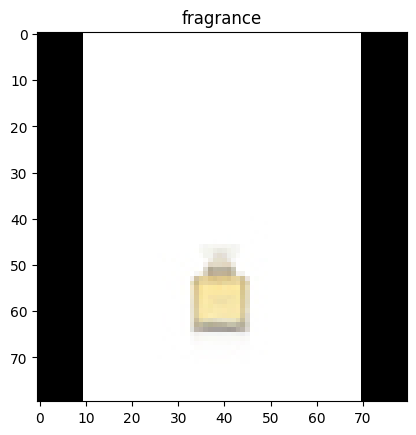


Top predictions:

        Perfumes: 99.60%
       Fragrance: 0.40%
            Lips: 0.00%
            Ties: 0.00%
     Accessories: 0.00%


In [23]:
class_names = df['subCategory'].unique()
class_names = [str(name) for name in class_names]

text = torch.stack([tokenizer(x)[0] for x in class_names]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in class_names])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

idx = 904


img = val_dataset[idx]["image"][None,:]
plt.imshow(img[0].permute(1, 2, 0)  ,cmap="gray")
plt.title(tokenizer(val_dataset[idx]["caption"], encode=False, mask=val_dataset[idx]["mask"][0])[0])
plt.show()
img = img.to(device)
with torch.no_grad():
  image_features = model.vision_encoder(img)
  text_features = model.text_encoder(text, mask=mask)


image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")

## Text to Image Retrieval with CLIP - E-commerce


Top 5 images for query 'bags':

Similarity: 0.52%


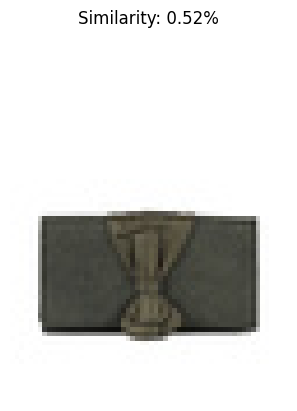

Similarity: 0.51%


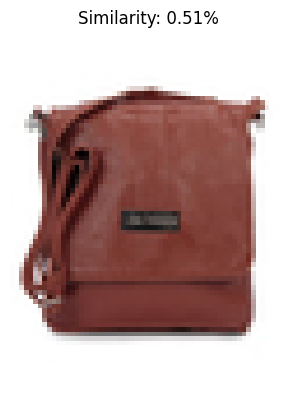

Similarity: 0.49%


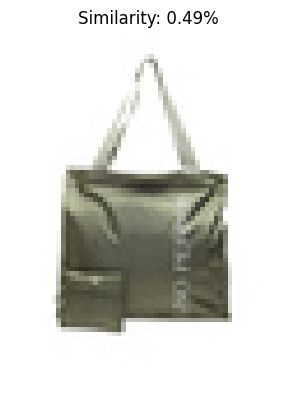

Similarity: 0.45%


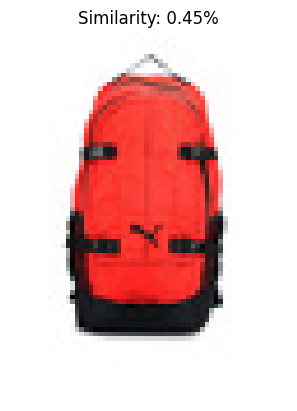

Similarity: 0.45%


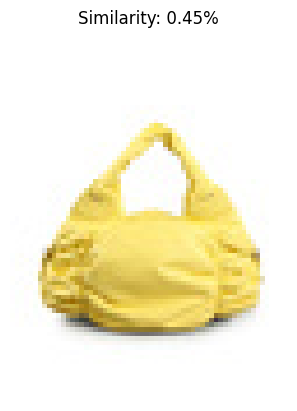

Similarity: 0.41%


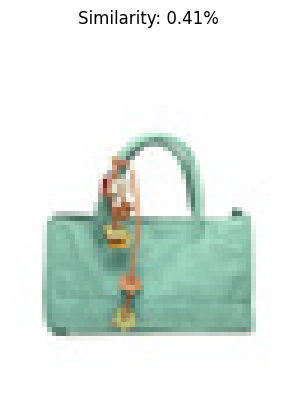

Similarity: 0.41%


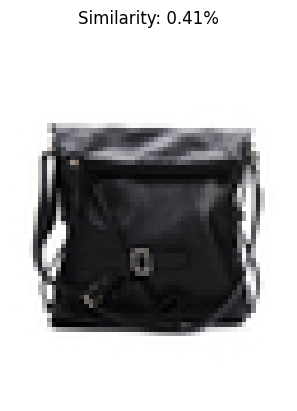

Similarity: 0.41%


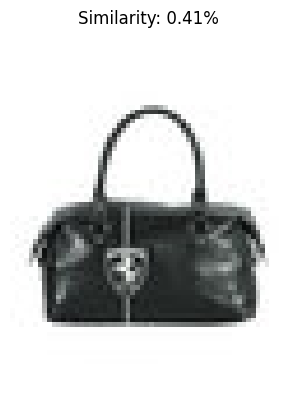

Similarity: 0.40%


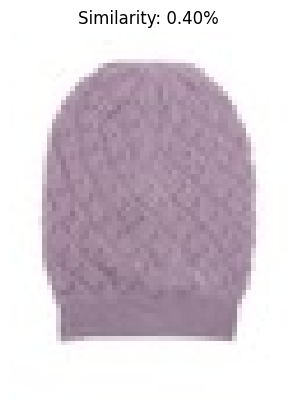

Similarity: 0.39%


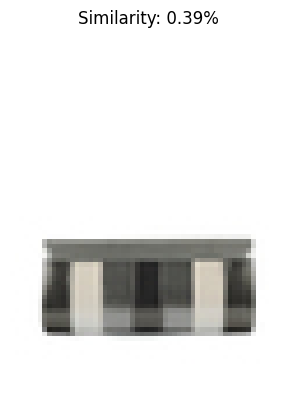

Similarity: 0.39%


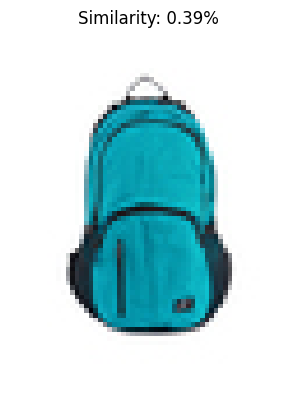

Similarity: 0.39%


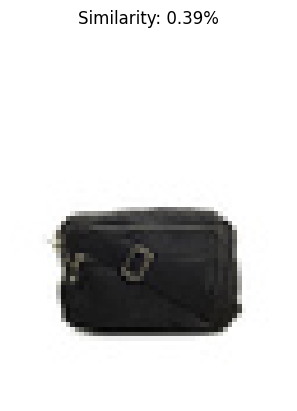

Similarity: 0.38%


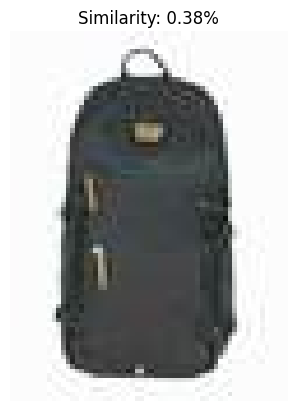

Similarity: 0.38%


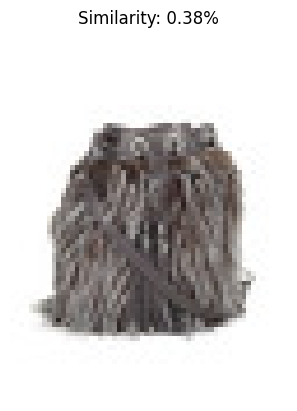

Similarity: 0.38%


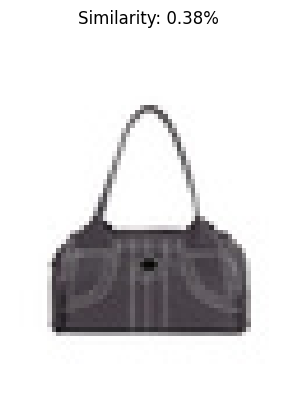

Similarity: 0.38%


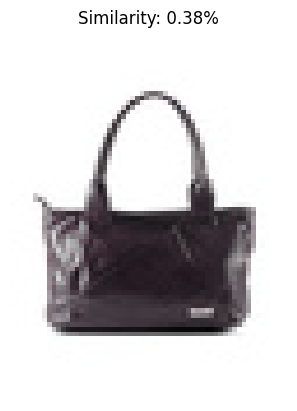

Similarity: 0.38%


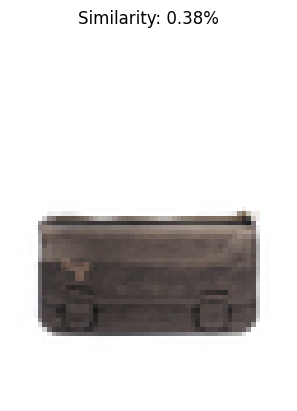

Similarity: 0.38%


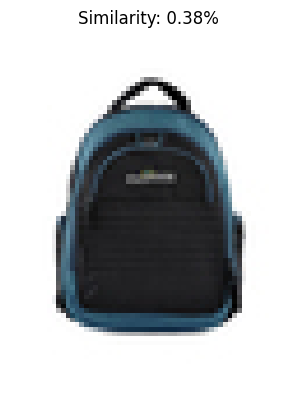

Similarity: 0.37%


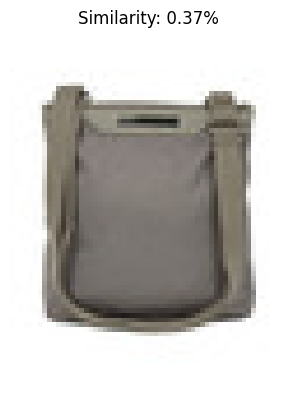

Similarity: 0.37%


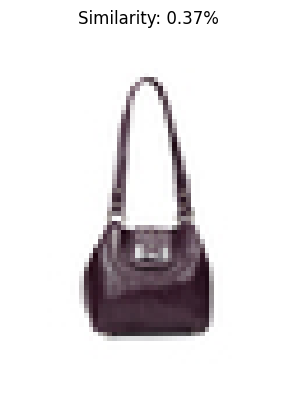

In [24]:
retrieval_model = CLIP(emb_dim, 
                       vit_layers, 
                       vit_d_model, 
                       img_size,
                       patch_size,
                       n_channels, 
                       vit_heads, 
                       vocab_size, 
                       max_seq_length, 
                       text_heads, 
                       text_layers,
                       text_d_model, 
                       retrieval = True).to(device)

retrieval_model.load_state_dict(torch.load(best_model_path, map_location=device))


# Step 1: Encode the text query using your tokenizer and TextEncoder
query = "bags"
query_text, query_mask = tokenizer(query)
query_text = query_text.unsqueeze(0).to(device)  # Add batch dimension
query_mask = query_mask.unsqueeze(0).to(device)

with torch.no_grad():
    query_features = retrieval_model.text_encoder(query_text, mask=query_mask)
    query_features /= query_features.norm(dim=-1, keepdim=True)

# Step 2: Encode all images in the dataset and store features
image_features_list = []
image_paths = []

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5)

with torch.no_grad():
    for batch in val_loader:
        # print(batch)
        images = batch["image"].to(device)
        features = retrieval_model.vision_encoder(images)
        features /= features.norm(dim=-1, keepdim=True)
        
        image_features_list.append(features)
        image_paths.extend(batch["id"])  # Assuming batch contains image paths or IDs

# Concatenate all image features
image_features = torch.cat(image_features_list, dim=0)

# Step 3: Compute similarity using the CLIP model's logic
# In your CLIP model, this is done using logits and temperature scaling
similarities = (query_features @ image_features.T) * torch.exp(model.temperature)

# Apply softmax to the similarities if needed
similarities = similarities.softmax(dim=-1)

# Retrieve top 5 matches
top_values, top_indices = similarities.topk(20)

# Step 4: Retrieve and display top N images
print(f"\nTop 5 images for query '{query}':\n")
for value, index in zip(top_values[0], top_indices[0]):
    print(f"Similarity: {100 * value.item():.2f}%")
    img_path = image_paths[index]
    
    # Display the image
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.title(f"Similarity: {100 * value.item():.2f}%")
    plt.axis('off')
    plt.show()



Top 5 images for query 'topwear':

Similarity: 0.09%


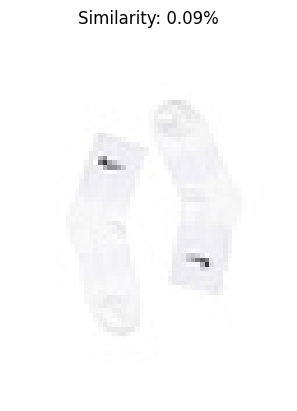

Similarity: 0.09%


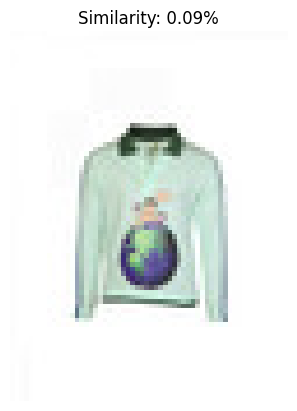

Similarity: 0.09%


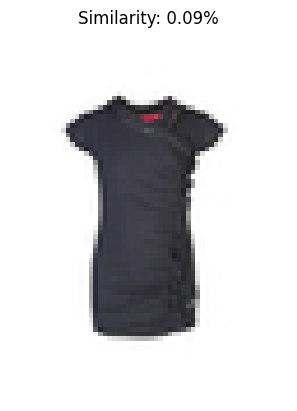

Similarity: 0.09%


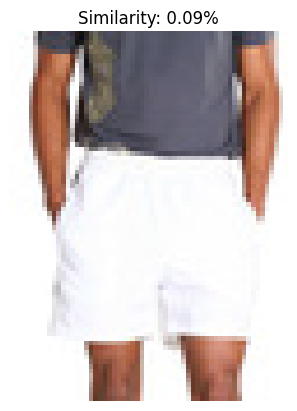

Similarity: 0.08%


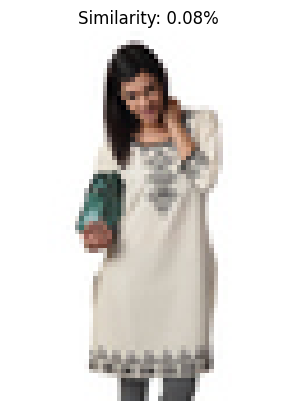

Similarity: 0.08%


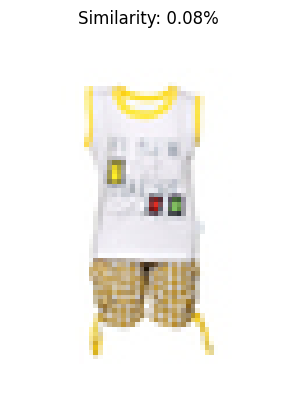

Similarity: 0.08%


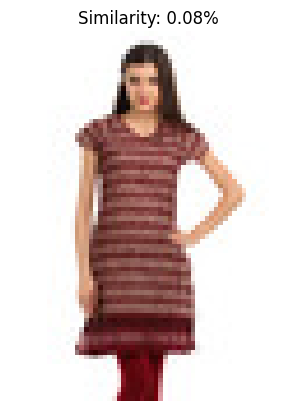

Similarity: 0.08%


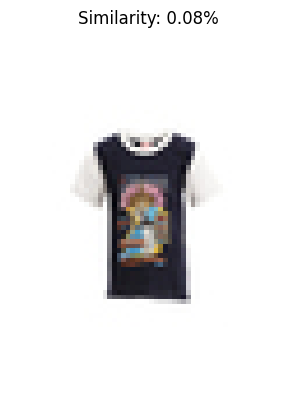

Similarity: 0.08%


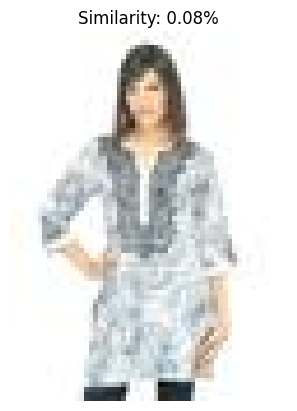

Similarity: 0.08%


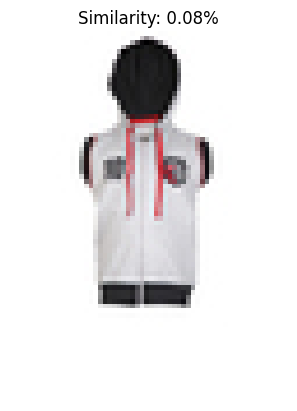

Similarity: 0.08%


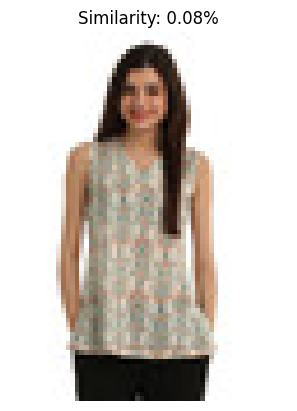

Similarity: 0.08%


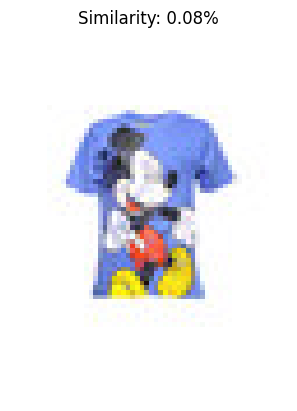

Similarity: 0.08%


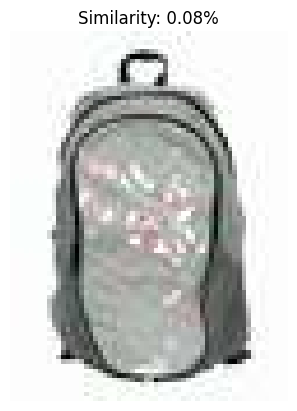

Similarity: 0.08%


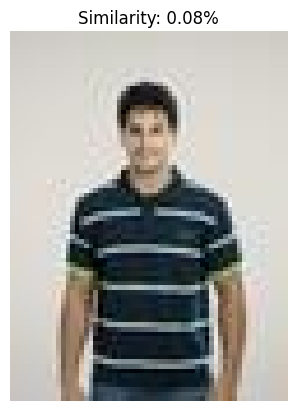

Similarity: 0.08%


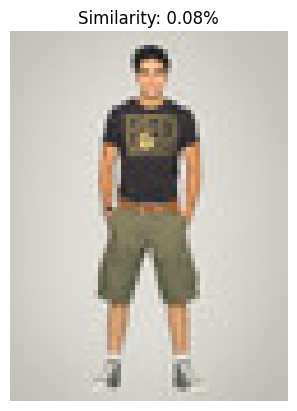

Similarity: 0.07%


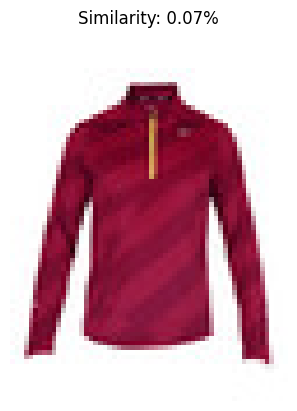

Similarity: 0.07%


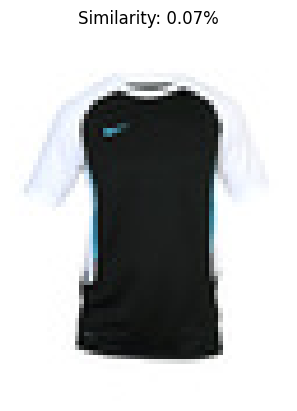

Similarity: 0.07%


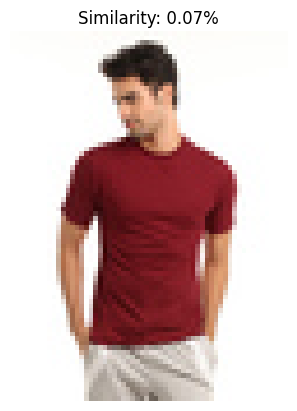

Similarity: 0.07%


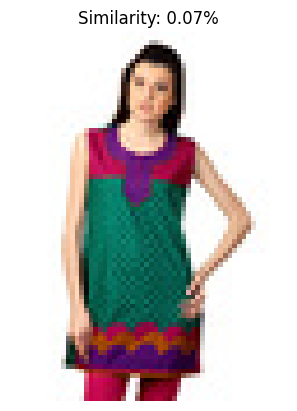

Similarity: 0.07%


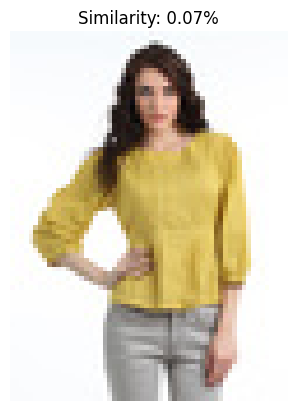

In [25]:
retrieval_model = CLIP(emb_dim, 
                       vit_layers, 
                       vit_d_model, 
                       img_size,
                       patch_size,
                       n_channels, 
                       vit_heads, 
                       vocab_size, 
                       max_seq_length, 
                       text_heads, 
                       text_layers,
                       text_d_model, 
                       retrieval = True).to(device)

retrieval_model.load_state_dict(torch.load(best_model_path, map_location=device))


# Step 1: Encode the text query using your tokenizer and TextEncoder
query = "topwear"
query_text, query_mask = tokenizer(query)
query_text = query_text.unsqueeze(0).to(device)  # Add batch dimension
query_mask = query_mask.unsqueeze(0).to(device)

with torch.no_grad():
    query_features = retrieval_model.text_encoder(query_text, mask=query_mask)
    query_features /= query_features.norm(dim=-1, keepdim=True)

# Step 2: Encode all images in the dataset and store features
image_features_list = []
image_paths = []

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5)

with torch.no_grad():
    for batch in val_loader:
        # print(batch)
        images = batch["image"].to(device)
        features = retrieval_model.vision_encoder(images)
        features /= features.norm(dim=-1, keepdim=True)
        
        image_features_list.append(features)
        image_paths.extend(batch["id"])  # Assuming batch contains image paths or IDs

# Concatenate all image features
image_features = torch.cat(image_features_list, dim=0)

# Step 3: Compute similarity using the CLIP model's logic
# In your CLIP model, this is done using logits and temperature scaling
similarities = (query_features @ image_features.T) * torch.exp(model.temperature)

# Apply softmax to the similarities if needed
similarities = similarities.softmax(dim=-1)

# Retrieve top 5 matches
top_values, top_indices = similarities.topk(20)

# Step 4: Retrieve and display top N images
print(f"\nTop 5 images for query '{query}':\n")
for value, index in zip(top_values[0], top_indices[0]):
    print(f"Similarity: {100 * value.item():.2f}%")
    img_path = image_paths[index]
    
    # Display the image
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.title(f"Similarity: {100 * value.item():.2f}%")
    plt.axis('off')
    plt.show()

In [26]:
import gradio as gr
import torch
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader

# Load the model and tokenizer
retrieval_model = CLIP(emb_dim, 
                       vit_layers, 
                       vit_d_model, 
                       img_size, 
                       patch_size, 
                       n_channels, 
                       vit_heads, 
                       vocab_size, 
                       max_seq_length, 
                       text_heads, 
                       text_layers, 
                       text_d_model, 
                       retrieval=True).to(device)
retrieval_model.load_state_dict(torch.load(best_model_path, map_location=device))

# Function to process the query and return the top 30 images
def retrieve_images(query):
    query_text, query_mask = tokenizer(query)
    query_text = query_text.unsqueeze(0).to(device)  # Add batch dimension
    query_mask = query_mask.unsqueeze(0).to(device)

    with torch.no_grad():
        query_features = retrieval_model.text_encoder(query_text, mask=query_mask)
        query_features /= query_features.norm(dim=-1, keepdim=True)

    # Step 2: Encode all images in the dataset and store features
    image_features_list = []
    image_paths = []

    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5)

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            features = retrieval_model.vision_encoder(images)
            features /= features.norm(dim=-1, keepdim=True)
            
            image_features_list.append(features)
            image_paths.extend(batch["id"])  # Assuming batch contains image paths or IDs

    # Concatenate all image features
    image_features = torch.cat(image_features_list, dim=0)

    # Step 3: Compute similarity using the CLIP model's logic
    similarities = (query_features @ image_features.T) * torch.exp(retrieval_model.temperature)
    similarities = similarities.softmax(dim=-1)

    # Retrieve top 30 matches
    top_values, top_indices = similarities.topk(30)

    # Step 4: Retrieve and display top N images
    images_to_display = []
    for value, index in zip(top_values[0], top_indices[0]):
        img_path = image_paths[index]
        img = Image.open(img_path).convert("RGB")
        images_to_display.append(np.array(img))

    return images_to_display

# Define the Gradio interface
def gradio_app(query):
    images = retrieve_images(query)
    return images

In [27]:
import gradio as gr

# Create Gradio Interface
with gr.Blocks() as interface:
    # Centered title
    gr.Markdown("<h1 style='text-align: center;'> 👒 Image Retrieval with CLIP -  👔👖 E-commerce Fashion 👚🥻</h1>")
    
    with gr.Row():
        # Textbox for query input
        query_input = gr.Textbox(placeholder="Enter your search query...", show_label=False, elem_id="custom-textbox")
        
        # Small submit button
        submit_btn = gr.Button("Search 🔍", elem_id="small-submit-btn")
    
    # Gallery output for displaying images
    gallery_output = gr.Gallery(label="Top 30 Matches").style(grid=[8], container=True)
    
    # Link the submit button to the function
    submit_btn.click(fn=gradio_app, inputs=query_input, outputs=gallery_output)

    # Custom CSS to make the submit button small and increase the font size in the textbox
    gr.HTML("""
    <style>
    #small-submit-btn {
        padding: 0.5rem 1rem;
        font-size: 0.8rem;
    }
    #custom-textbox input {
        font-size: 1.5rem;
    }
    </style>
    """)

# Launch the app
interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 3.50.0, however version 4.44.1 is available, please upgrade.
--------
